In [1]:
# data wraggling functions 
import pandas as pd
import numpy as np
from langdetect import detect
import time

# EDA
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
import seaborn as sns

# NLP functions
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

import pickle

## load in the cleaned data

In [78]:
project_data_from_sql = pickle.load(open("pickle/project_data_complete.pkl", "rb"))
project_data_from_sql.shape

(2206, 27)

# feature engineering

## check the effects of time

In [89]:
# get some time related information
data_time = pd.DataFrame()
data_time['launch_year'] = project_data_from_sql.apply(lambda row: time.gmtime(row['launch']).tm_year, axis=1)
data_time['launch_month'] = project_data_from_sql.apply(lambda row: time.gmtime(row['launch']).tm_mon, axis=1)
data_time['launch_wday'] = project_data_from_sql.apply(lambda row: time.gmtime(row['launch']).tm_wday, axis=1)
data_time['percent'] = np.log(project_data_from_sql['percent']+0.01)

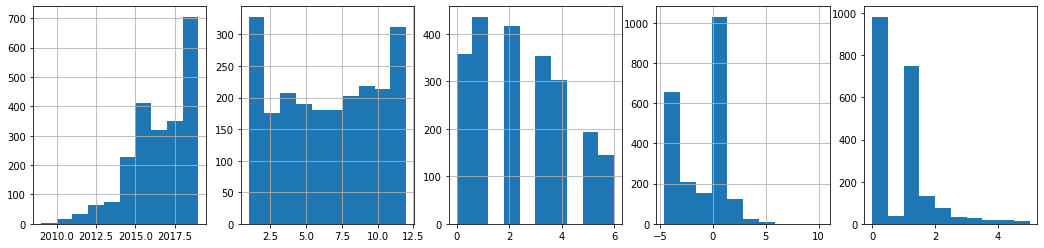

In [90]:
fig, axes = plt.subplots(figsize=(18, 4), nrows=1, ncols=5)

data_time['launch_year'].hist(ax=axes[0])
data_time['launch_month'].hist(ax=axes[1])
data_time['launch_wday'].hist(ax=axes[2])
data_time['percent'].hist(ax=axes[3]) # this is logged percent value
axes[4].hist(project_data_from_sql['percent'], range=(0, 5))
plt.show()

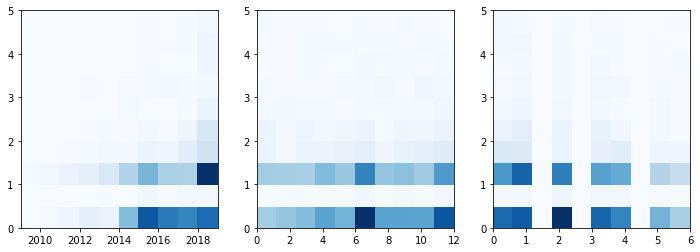

In [91]:
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)

axes[0].hist2d(x= data_time['launch_year'], y= project_data_from_sql['percent'], 
               range = [[2009,2019],[0,5]], cmap='Blues')
axes[1].hist2d(x= data_time['launch_month'], y= project_data_from_sql['percent'], 
               range = [[0,12],[0,5]], cmap='Blues')
axes[2].hist2d(x= data_time['launch_wday'], y= project_data_from_sql['percent'], 
               range = [[0, 6],[0,5]], cmap='Blues')
plt.show()
# 2016 had a lot of failed projects,
# 2018-2019 seemed to have more successful projects, but there are also more projcet since 2018
# no obvious effects of month
# Tuesday seems to be the best day to launch

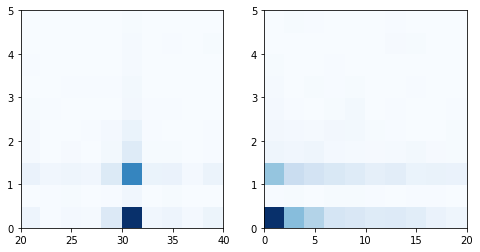

In [92]:
fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2)

axes[0].hist2d(x= project_data_from_sql['days_active'], 
               y= project_data_from_sql['percent'], 
               range = [[20,40],[0,5]], cmap='Blues')
axes[1].hist2d(x= project_data_from_sql['days_draft'], 
               y= project_data_from_sql['percent'], 
               range = [[0,20],[0,5]], cmap='Blues')
plt.show()

# not a whole lot of variations here

In [93]:
# create feature of weekday it's launched
project_data_from_sql['launch_wday'] = project_data_from_sql.apply(lambda x: 
                                                                   time.gmtime(x['launch']).tm_wday, axis=1)

### I decided to not incluce any time related features in the final models:
b.c. this is hard to know before launch. And to improve user experience

## filter such that all entries are in english and have a story

In [6]:
# make function to handle exceptions:
def trydetect(s):
    try:
        r = detect(s)
    except:
        r = "NA"
    return r

In [7]:
# detect the language of the blurb
project_data_from_sql['language'] = project_data_from_sql.apply(lambda x: trydetect(x['blurb']), axis=1)
# decide if a proposals really has a story section, some had them in pictures thus not in my data
project_data_from_sql['keep_story'] = project_data_from_sql.apply(lambda x: 
                                                                  len(x['story']) > len(x['blurb']), axis=1)
# filter out non-english entries and entries without much stories
data_project = project_data_from_sql[(project_data_from_sql.keep_story == 1) & 
                                     (project_data_from_sql.language == "en")].reset_index()
data_project.shape
# 2107,44

## add text length features for title and blurb

In [8]:
# word count and length in title and blurb
data_project['title_words'] = data_project['project_name'].str.split().str.len()
data_project['title_l'] = data_project['project_name'].str.len()
data_project['blurb_words'] = data_project['blurb'].str.split().str.len()
data_project['blurb_l'] = data_project['blurb'].str.len()

## Preprocess text information

In [9]:
# define function to lemmatize long-form text
def lemmatizer(sentence):
    token_words = word_tokenize(sentence)
    lem_sentence=[]
    for word in token_words:
        lemma = wnl.lemmatize(word)
        lem_sentence.append(lemma)
        lem_sentence.append(" ")
    return "".join(lem_sentence)

In [10]:
# make preprocessing pipeline:
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

def preproc(text):
    l = re.sub(r'http\S+',' ', text) # remove links
    n = re.sub(r'[0-9]+', ' ', l) # remove numbers
    s = re.sub(r'[^\w]',' ', n)  # remove symbols
    w = pattern.sub('', s) # remove stopwords
    p = lemmatizer(w) # lemmatize all words
    return p

In [11]:
# combine the apply the preprocessing pipeline to all available data
data_project['story_tb'] = data_project["project_name"].map(str) + data_project["blurb"].map(str) +data_project["story"].map(str)
data_project['story_p'] = data_project.apply(lambda x: preproc(x['story_tb']), axis=1)

In [12]:
# total text length
data_project['total_words'] = data_project['story_p'].str.split().str.len()

## EDA on the response variable

In [13]:
data_project['state_b'] = data_project.apply(lambda x: x['state'] == 'successful', axis=1)

In [14]:
data_project['state_b'].sum()/len(data_project['state_b'])
# 54% of the projects in my data are successful
# it's quite balanced

0.540579022306597

In [15]:
# add log-transformed version of some variables that are highly skewed

data_project['l_goal'] = np.log10(data_project['goal_usd'] + 1)
data_project['l_pledge'] = np.log10(data_project['pledge_usd'] + 1)
data_project['l_percent'] = np.log10(data_project['percent']*100+1)
data_project['l_backers'] = np.log10(data_project['backers']+ 1)

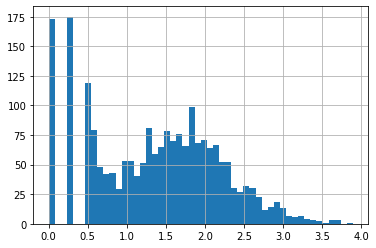

In [232]:
# look at backer distribution
np.log10(data_project['backers']+ 1).hist(bins = 50)
plt.show()
# mostly normally distributed
# many projects have only a few backers

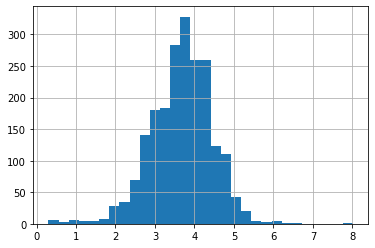

In [223]:
np.log10(data_project['goal_usd'] + 1).hist(bins = 30)
# there is a lot of variation in goal, but very much look like a normal distribution

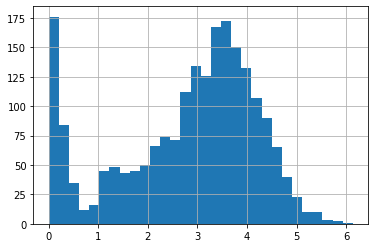

In [224]:
np.log10(data_project['pledge_usd'] + 1).hist(bins = 30)
# a large number of projects received very little money

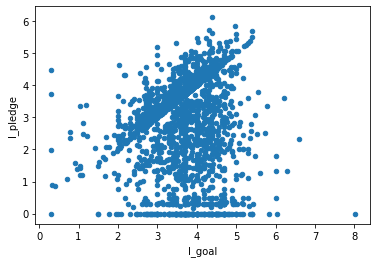

In [268]:
data_project.plot.scatter('l_goal', 'l_pledge')
# a lot of variation here
# many project raise nearly no money and many just above their goal
# also means that a lot of people have realistic understanding of how much the proposal is worth
# so predicting how much will be pledged is less informative, since it's limited by the goal
# but there are at least three distinctive groups of projects here

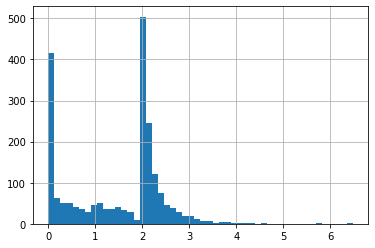

In [225]:
np.log10(data_project['percent']*100+1).hist(bins = 50)
plt.show()
# again large numbers of projects raise almost no money or about what they ask for
# in light of this and the previous figure, 
# I will engineer categories that contain projects that:
# raise almost none, some, 100%, and better than expected

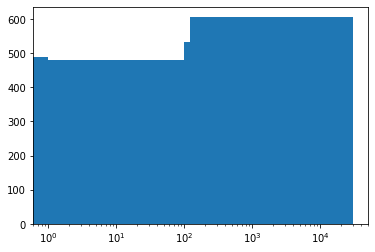

In [303]:
plt.hist(data_project['percent']*100, bins = [0, 1, 100, 120, 30000])
plt.xscale('log')
# decide the best binning boundaries 

In [16]:
# large numbers of projects raise almost no money or about what they ask for
# I will engineer categories that contain projects that:
# raise almost none, some, 100%, better than expected, and superstars
max_bin = max(data_project['percent']*100)+1
data_project['performance'] = pd.cut(data_project['percent']*100,
                                 bins = [0, 1, 100, 120, max_bin], 
                                 labels = ["fail", "some", "goal", "great"],
                                 right = False)
data_project['performance_n'] = pd.cut(data_project['percent']*100,
                                 bins = [0, 1, 100, 120, max_bin], 
                                 labels = [0,1,2,3],
                                 right = False)

In [17]:
sum_count = data_project[['index','performance']].groupby('performance').count().apply(sum)
data_project[['index','performance']].groupby('performance').count()/sum_count
# the categores are pretty even

,index
performance,
fail,0.231609
some,0.227812
goal,0.252017
great,0.288562


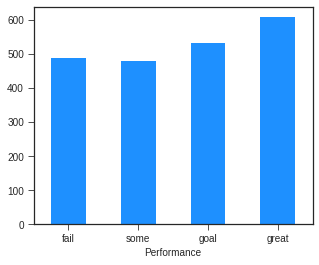

In [18]:
data_project[['index','performance']].groupby('performance').count().plot.bar(legend = False, 
                                                                              figsize = (5,4), 
                                                                              rot=0,
                                                                             color = 'dodgerblue')
plt.xlabel("Performance")
plt.show()

## EDA on predictor variables

In [336]:
data_project.groupby('performance').mean()
# staff_pick is important but not for becoming "great"
# longer title
# blurb length is not
# totla length seems important

,index,project_id,project_id,goal,pledge,deadline,create,launch,staff_pick,backers,...,title_l,blurb_words,blurb_l,total_words,total_l,state_b,l_goal,l_pledge,l_percent,l_backers
performance,,,,,,,,,,,,,,,,,,,,,
fail,1177.235656,1.050628e+09,1.050628e+09,272111.389344,50.423258,1.467783e+09,1.461738e+09,1.464615e+09,0.002049,1.528689,...,31.057377,18.885246,111.303279,211.323770,1483.790984,0.0,4.079994,0.739659,0.048871,0.303922
some,1176.012500,1.056563e+09,1.056563e+09,39651.452083,4299.087479,1.470420e+09,1.463242e+09,1.467426e+09,0.062500,27.408333,...,35.785417,18.864583,112.429167,312.802083,2194.270833,0.0,3.788921,2.733958,1.020765,1.115063
goal,1037.562030,1.057030e+09,1.057030e+09,12849.736842,13761.047387,1.469310e+09,1.462616e+09,1.466537e+09,0.172932,105.686090,...,34.575188,18.665414,110.481203,369.526316,2601.120301,1.0,3.628372,3.655300,2.031010,1.774201
great,1036.334975,1.103096e+09,1.103096e+09,10730.543514,44556.504204,1.494642e+09,1.487927e+09,1.492084e+09,0.167488,307.060755,...,39.050903,17.878489,107.594417,439.515599,3065.799672,1.0,3.287421,3.731812,2.449755,2.025930


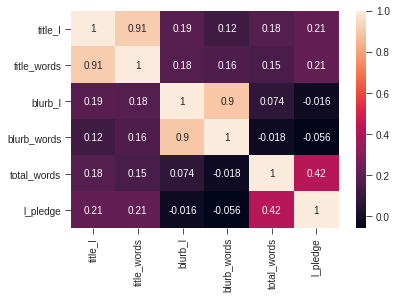

In [21]:
corr = data_project[['title_l', 'title_words','blurb_l', 'blurb_words', 'total_words', "l_pledge"]].corr()
ax = sns.heatmap(corr, annot = True)
# really high correlation within categories, especially total words and total_l
# will only use total_words and title_length

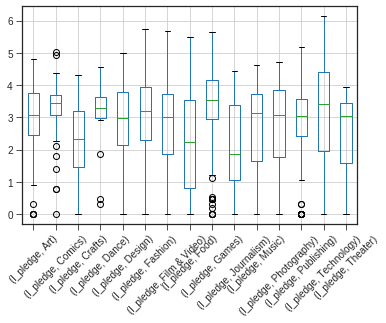

In [29]:
data_project[['name_parent','l_pledge']].pivot(
    columns=data_project[['name_parent','l_pledge']].columns[0],
    index=data_project[['name_parent','l_pledge']].index).boxplot(rot = 45)
plt.show()

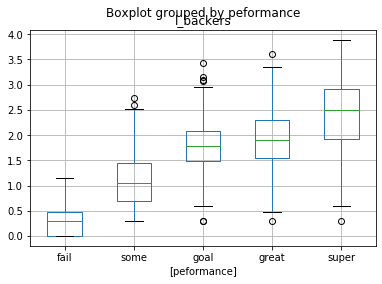

In [264]:
data_project.boxplot(column=['l_backers'], by=['peformance'])
# the more backers the better performance

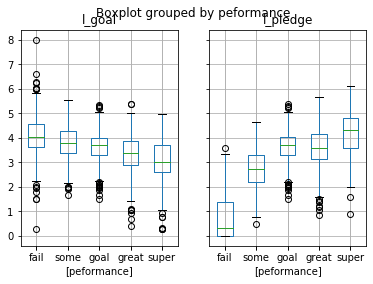

In [272]:
data_project.boxplot(column=['l_goal', 'l_pledge'], by=['peformance'])
plt.show()
# there is slight downward trend between goal and performance
# and an upward trend between pledge and performance, which makes sense

# train-test-validation split

In [30]:
from sklearn.model_selection import train_test_split

In [85]:
data_project = data_project.sample(frac=1).reset_index(drop=True)
data_y = data_project[['performance', 'performance_n', 'state_b', 'l_pledge']]
data_x = data_project[['name_parent', 'goal_usd', 'story_p', 'title_l', 'total_words']]
# name_parent is the name of the main category

In [86]:
X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, test_size = 0.20, random_state = 61)

In [87]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.20, random_state = 59)

# feature engineering and model testing

In [38]:
# feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
from scipy.sparse import hstack

# model testing
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

## tf-idf

In [88]:
tfidf = TfidfVectorizer()
# note the default normalizes the output matrix
tfidf_m = tfidf.fit_transform(x_train['story_p'])
tfidf_val = tfidf.transform(x_val['story_p'])

In [89]:
tfidf_m.shape

(1348, 38377)

# add other project information

In [90]:
encoder = onehot.fit_transform(x_train[['name_parent']])
encoded_val = onehot.transform(x_val[['name_parent']])

In [91]:
x_train_info = x_train[['goal_usd', 'title_l', 'total_words']]
x_train_sparse = hstack([tfidf_m, encoder]).toarray()
x_train_full = np.concatenate((x_train_info, x_train_sparse), axis= 1)

In [92]:
x_val_info = x_val[['goal_usd', 'title_l', 'total_words']]
x_val_sparse = hstack([tfidf_val, encoded_val]).toarray()
x_val_full = np.concatenate((x_val_info, x_val_sparse), axis= 1)

# Modeling pledge amount

In [44]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import ElasticNet, Lasso # sparse models
from sklearn.svm import LinearSVR
from sklearn.linear_model import Ridge # regularization properties
from sklearn.kernel_ridge import KernelRidge # add kernel to ridge

In [93]:
r_gcr = GaussianProcessRegressor()
r_gcr.fit(x_train_full, y_train['l_pledge'])
r_gcr_predict = r_gcr.predict(x_val_full)
print(r2_score(y_val['l_pledge'], r_gcr_predict ), mean_squared_error(y_val['l_pledge'], r_gcr_predict ))
# Gaussian Process does worse than random, as expected2

-4.154505812912845 10.268273881614283


In [94]:
r_ls = Lasso()
r_ls.fit(x_train_full, y_train['l_pledge'])
r_ls_predict = r_ls.predict(x_val_full)
print(r2_score(y_val['l_pledge'], r_ls_predict ), mean_squared_error(y_val['l_pledge'], r_ls_predict ))
# performs pretty poorly as well: 0.1646342513671024 1.6641293287115324

0.1646342513671024 1.6641293287115324


In [95]:
# elastic net model for sparse model with regularization
r_en = ElasticNet()
r_en.fit(x_train_full, y_train['l_pledge'])
r_en_predict = r_en.predict(x_val_full)
print(r2_score(y_val['l_pledge'], r_en_predict ), mean_squared_error(y_val['l_pledge'], r_en_predict ))
# takes a bit to train
# performs similarly to lasso: 0.1648721701254212 1.6636553715446065

0.1648721701254212 1.6636553715446065


In [96]:
r_svr = LinearSVR()
r_svr.fit(x_train_full, y_train['l_pledge'])
r_svr_predict = r_svr.predict(x_val_full)
print(r2_score(y_val['l_pledge'], r_svr_predict ), mean_squared_error(y_val['l_pledge'], r_svr_predict ))
# failed to converge

-884.4784824938466 1763.958739118169


/home/sheng/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [98]:
# ridge model
ridge = Ridge()
ridge.fit(x_train_full, y_train['l_pledge'])
ridge_predict = ridge.predict(x_val_full)
print(r2_score(y_val['l_pledge'], ridge_predict ), mean_squared_error(y_val['l_pledge'], ridge_predict ))
# performs okay: 0.35087355683191646 1.293122627886095
# with full tf-idf matrix and no change in regularization

0.35087355683191646 1.293122627886095


/home/sheng/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.09526e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


In [99]:
r_kridge = KernelRidge()
r_kridge.fit(x_train_full, y_train['l_pledge'])
r_kridge_predict = r_kridge.predict(x_val_full)
print(r2_score(y_val['l_pledge'], r_kridge_predict ), mean_squared_error(y_val['l_pledge'], r_kridge_predict ))
# performs similarly to ridge, maybe a little bit worse: 0.33921527805265406 1.3163470462568698

/home/sheng/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.92275e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


0.33921527805265406 1.3163470462568698


## dive into the best model:

### reducing model dimension and hyperparameter tuning

In [100]:
#feature selection?
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# make pipeline
pipe_fs = Pipeline([('fs', SelectKBest(chi2, k = 1000)), ('ridge', Ridge())])

# train model
pipe_fs.fit(x_train_full, y_train['l_pledge'].astype('int'))

# test model performance
pipe_fs_predict = pipe_fs.predict(x_val_full)
print(r2_score(y_val['l_pledge'], pipe_fs_predict ), mean_squared_error(y_val['l_pledge'], pipe_fs_predict))

# feature selection doesn't do a good job selecting the useful features

0.13188866056369597 1.7293617112111914


/home/sheng/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.23799e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [176]:
tfidf_r = TfidfVectorizer(max_features = 1500)
# note the default normalizes the output matrix
tfidf_m_r = tfidf_r.fit_transform(x_train['story_p'])
tfidf_val_r = tfidf_r.transform(x_val['story_p'])

x_train_info = x_train[['title_l', 'total_words']]
x_train_sparse_r = hstack([tfidf_m_r, encoder]).toarray()
x_train_full_r = np.concatenate((x_train_sparse_r, x_train_info), axis= 1)

x_val_info = x_val[['title_l', 'total_words']]
x_val_sparse_r = hstack([tfidf_val_r, encoded_val]).toarray()
x_val_full_r = np.concatenate((x_val_sparse_r, x_val_info), axis= 1)

ridge_r = Ridge()
ridge_r.fit(x_train_full_r, y_train['l_pledge'])
ridge_r_predict = ridge_r.predict(x_val_full_r)
print(r2_score(y_val['l_pledge'], ridge_r_predict ), mean_squared_error(y_val['l_pledge'], ridge_r_predict ))
# reducing the max_features to 2000 seem to be useful: 0.36749008867804944 1.2600208900761924
# reducing to 1500 is better 0.37819561196760776 1.2386944527467787
# reducing to 1200 is too far: 0.36460933991467526 1.265759620103879

0.3751460341229347 1.244769506625651


In [177]:
# look at the feature importance of the words:
result_features = pd.DataFrame({'feature' : tfidf_r.get_feature_names(), 'importance': ridge_r.coef_[:1500]})
sorted_features = result_features.sort_values(axis = 'index', by = ['importance'])

In [178]:
resutls_bad_words = sorted_features.head(100)
resutls_good_words = sorted_features.tail(100)

In [179]:
# tuning the regularization term
ridge_a = Ridge(alpha = 0.8)
ridge_a.fit(x_train_full_r, y_train['l_pledge'])
ridge_a_predict = ridge_a.predict(x_val_full_r)
print(r2_score(y_val['l_pledge'], ridge_a_predict ), mean_squared_error(y_val['l_pledge'], ridge_a_predict ))
# reducing alpha value does not improve model performance

0.3724333165413135 1.2501735022951825


In [180]:
train_sizes, train_scores, test_scores = \
    learning_curve(ridge_r, x_val_full_r, y_val['l_pledge'])

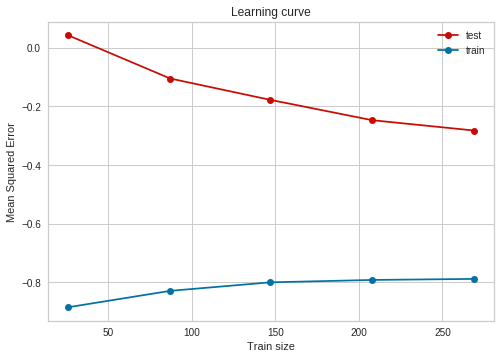

In [181]:
plt.figure()

plt.plot(train_sizes, -test_scores.mean(1), 'o-', color="r",
         label="test")
plt.plot(train_sizes, -train_scores.mean(1), 'o-', color="b",
         label="train")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curve')
plt.legend(loc="best")

plt.show()

# looks reasonable
# more data would be nice

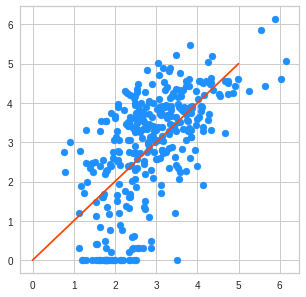

In [182]:
from matplotlib.pyplot import figure
figure(figsize=(5,4.9))
plt.scatter(ridge_r_predict, y_val['l_pledge'], color = "dodgerblue")
plt.plot( [0,5],[0,5], color = "orangered" )

## try adding bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor
regr = BaggingRegressor(base_estimator = Ridge(), n_estimators=10).fit(x_train_full_r, y_train['l_pledge'])
regr_predict = regr.predict(x_val_full_r)
print(r2_score(y_val['l_pledge'], regr_predict ), mean_squared_error(y_val['l_pledge'], regr_predict ))
# bagging did not improve model performance: 0.3675219898705723 1.2599573398166986

## try adding state_b response variable

In [115]:
# ridge model
rm_ridge = Ridge()
rm_ridge.fit(x_train_full_r, y_train[['state_b','l_pledge']])
rm_ridge_predict = rm_ridge.predict(x_val_full_r)
# this also doesn't help: 0.32473708806285845 0.7096708446672868

/home/sheng/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.09669e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


In [116]:
print(r2_score(y_val[['state_b', 'l_pledge']], rm_ridge_predict ), 
      mean_squared_error(y_val[['state_b', 'l_pledge']], rm_ridge_predict ))

0.32473708806285845 0.7096708446672868


# final test of the model performance

In [ ]:
# combine train and val datasets

# production model

In [ ]:
# train on full dataset

# save things for the app:

In [183]:
with open("pickle/appv2models.pkl", "wb") as f:
    pickle.dump([ridge_r, tfidf_r, onehot, resutls_good_words, resutls_bad_words, result_features], f)